In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64


On device: cuda


# Hierarchical Refinement: Simple Demo

First, we will generate a simple synthetic toy dataset to visualize the Refinement mapping. This dataset is generated by sampling points ￼ from a 2-dimensional normal distribution and defining a trivial piecewise ODE System using these samples as an initial condition.

We plot: (the original sampled points) in blue, (the ODE-transformed points) in red.

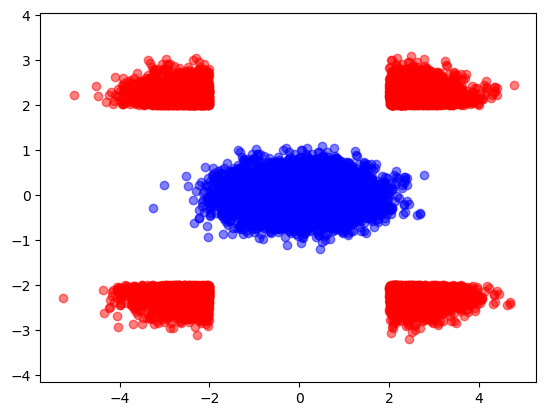

In [2]:
import toy_example

X1, X2 = toy_example.generate_sample_data(N = 8192)

# We'll first evaluate Refinement with a full-rank cost matrix $\mathbf{C}$

Refinement's default initialization can take in a full-cost, i.e. if one wants to specify an arbitrary, general cost functional defined entrywise as $\mathbf{C}_{ij} = c(\mathbf{x}_{i}, \mathbf{x}_{j} )$.


In [3]:
sys.path.insert(0, '../src/')
import HR_OT

X = torch.from_numpy(X1).type(torch.DoubleTensor).to(device)
Y = torch.from_numpy(X2).type(torch.DoubleTensor).to(device)
C = torch.cdist(X, Y)
#C = C / C.max()

n = X1.shape[0]

First, we call the rank-annealing scheduler to find a sequence of ranks which minimizes the number of calls of the low-rank optimal transport subroutine used, while remaining under a machine-specific maximal rank. The parameters include:

- n : The size of the dataset

- $\kappa$ or hierarchy\_depth : The depth of the hierarchy of levels used in the refinement strategy.

- max\_Q : The maximal terminal rank at the base case

- max\_rank : The maximal rank of the intermediate sub-problems

  

In [4]:
import rank_annealing

rank_schedule = rank_annealing.optimal_rank_schedule( n , hierarchy_depth = 6, max_Q = 2**10, max_rank = 2**10 )

Optimized rank-annealing schedule: [16, 512]


First, we evaluate and visualize the mapping output by Refinement using the full-rank cost $\mathbf{C}$

Iteration: 0
Last level, rank chunk-size 512 with 16 iterations to completion.
0/16 of final-level iterations to completion
Iteration: 0
1/16 of final-level iterations to completion
Iteration: 0
2/16 of final-level iterations to completion
Iteration: 0
3/16 of final-level iterations to completion
Iteration: 0
4/16 of final-level iterations to completion
Iteration: 0
5/16 of final-level iterations to completion
Iteration: 0
6/16 of final-level iterations to completion
Iteration: 0
7/16 of final-level iterations to completion
Iteration: 0
8/16 of final-level iterations to completion
Iteration: 0
9/16 of final-level iterations to completion
Iteration: 0
10/16 of final-level iterations to completion
Iteration: 0
11/16 of final-level iterations to completion
Iteration: 0
12/16 of final-level iterations to completion
Iteration: 0
13/16 of final-level iterations to completion
Iteration: 0
14/16 of final-level iterations to completion
Iteration: 0
15/16 of final-level iterations to completion


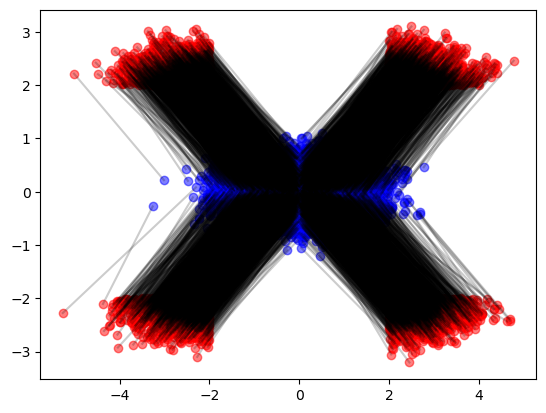

Refinement Cost: 2.8351883448556476


In [5]:
solver_params = {
            'gamma' : 90,
            'max_iter' : 25,
            'min_iter' : 20,
            'max_inneriters_balanced' : 200,
            'max_inneriters_relaxed' : 200
        }

hrot = HR_OT.HierarchicalRefinementOT(C, rank_schedule,
                                      base_rank=1, device=device,
                                      solver_params=solver_params)

F = hrot.run(return_as_coupling=False)

for pair in F:
    idx1, idx2 = pair
    idx1, idx2 = idx1.cpu().numpy(), idx2.cpu().numpy()
    x_values = X1[idx1, 0], X2[idx2, 0]
    y_values = X1[idx1, 1], X2[idx2, 1]
    plt.plot(x_values, y_values, c='black', alpha=0.2)

plt.scatter(X1[:,0], X1[:,1], c='b', label=r'Set A', alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], c='r', label=r'Set B', alpha=0.5)

plt.show()

cost_hr_ot = hrot.compute_OT_cost()
print(f'Refinement Cost: { cost_hr_ot.item() }')

Next, we use init\_from\_point\_clouds to initialize the class using datasets $\mathbf{X}, \mathbf{Y}$ and run without initializing with a full-rank cost matrix. This ensures _linear_ space in both matrices, and is the variant used for scaling to massive datasets, e.g. ImageNet.

Iteration: 0
Last level, rank chunk-size 512 with 16 iterations to completion.
0/16 of final-level iterations to completion
Iteration: 0
1/16 of final-level iterations to completion
Iteration: 0
2/16 of final-level iterations to completion
Iteration: 0
3/16 of final-level iterations to completion
Iteration: 0
4/16 of final-level iterations to completion
Iteration: 0
5/16 of final-level iterations to completion
Iteration: 0
6/16 of final-level iterations to completion
Iteration: 0
7/16 of final-level iterations to completion
Iteration: 0
8/16 of final-level iterations to completion
Iteration: 0
9/16 of final-level iterations to completion
Iteration: 0
10/16 of final-level iterations to completion
Iteration: 0
11/16 of final-level iterations to completion
Iteration: 0
12/16 of final-level iterations to completion
Iteration: 0
13/16 of final-level iterations to completion
Iteration: 0
14/16 of final-level iterations to completion
Iteration: 0
15/16 of final-level iterations to completion


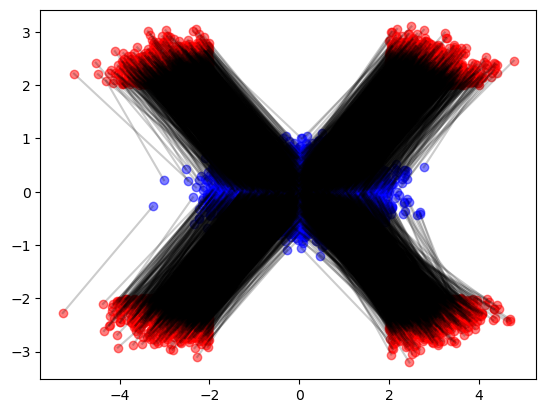

Refinement Cost: 2.839838230802344


In [6]:

hrot_lr = HR_OT.HierarchicalRefinementOT.init_from_point_clouds(X, Y,
                                                                rank_schedule, base_rank=1,
                                                                device=device,
                                                                  solver_params=solver_params)

F_lr = hrot_lr.run(return_as_coupling=False)

for pair in F_lr:
    idx1, idx2 = pair
    idx1, idx2 = idx1.cpu().numpy(), idx2.cpu().numpy()
    x_values = X1[idx1, 0], X2[idx2, 0]
    y_values = X1[idx1, 1], X2[idx2, 1]
    plt.plot(x_values, y_values, c='black', alpha=0.2)

plt.scatter(X1[:,0], X1[:,1], c='b', label=r'Set A', alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], c='r', label=r'Set B', alpha=0.5)

plt.show()

cost_hr_ot = hrot_lr.compute_OT_cost()
print(f'Refinement Cost: { cost_hr_ot.item() }')

We also add a brief comparison against Sinkhorn, assessing the cost and visualizing the barycentric mapping as a comparison.

In [7]:

import jax
#from jax.config import config
#config.update("jax_enable_x64", True)
import jax.numpy as jnp
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

C_np = C.cpu().numpy()
geom = Geometry(C_np, epsilon=0.05) # This epsilon was default in ott-jax during benchmarking
ot_problem = linear_problem.LinearProblem(geom)
solver = sinkhorn.Sinkhorn()

ot_solution = solver(ot_problem)
P_sinkhorn = np.array(ot_solution.matrix, dtype=np.float64)
cost_Sinkhorn = np.sum( C_np * P_sinkhorn )

print(f'Sinkhorn Cost: { cost_Sinkhorn }')

/home/ph3641/.local/lib/python3.12/site-packages/ott/problems/linear/linear_problem.py:70: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.full((n,), fill_value=1.0 / n, dtype=self.dtype)
/home/ph3641/.local/lib/python3.12/site-packages/ott/problems/linear/linear_problem.py:78: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.full((m,), fill_value=1.0 / m, dtype=self.dtype)
/home/ph3641/.local/lib/python3.12/site-packages/ott/solvers/linear/sinkhorn.py:924: UserWar

Sinkhorn Cost: 2.8505786894503293


In [8]:
X2_Sink = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ X2

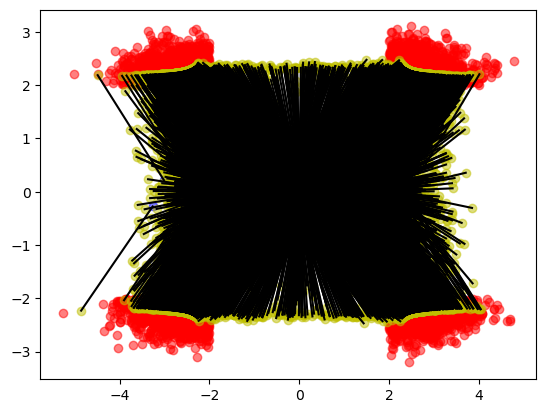

In [9]:

for idx1 in range(X1.shape[0]):
    x_values = X1[idx1, 0], X2_Sink[idx1, 0]
    y_values = X1[idx1, 1], X2_Sink[idx1, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(X1[:,0], X1[:,1], c='b', label=r'Initial points', alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], c='r', label=r'Final points', alpha=0.5)
plt.scatter(X2_Sink[:,0], X2_Sink[:,1], c='y', label=r'Barycentric projection', alpha=0.5)

plt.show()
